In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from model import fit_dataarray, apply_model

## Reference data
BCRA tile 0:45 reference from Malkin

In [2]:
reference = pd.read_excel('data/malkin set with test errors and assigned targets 10_18_18 and color calculations.xlsx',
                       sheet_name='target reflectance', usecols='A:M')
reference = reference.to_xarray()
reference = reference.set_coords('wavelength').to_array('tile').swap_dims({'index': 'wavelength'}).drop('index')
reference = reference.rename('reflectance')
reference

<xarray.DataArray 'reflectance' (tile: 12, wavelength: 81)>
array([[0.532 , 0.5444, 0.5548, ..., 0.604 , 0.6029, 0.6019],
       [0.1816, 0.1893, 0.1961, ..., 0.2264, 0.2252, 0.224 ],
       [0.1761, 0.1832, 0.191 , ..., 0.252 , 0.2511, 0.2501],
       ...,
       [0.0484, 0.0517, 0.0543, ..., 0.1742, 0.1728, 0.1713],
       [0.1574, 0.1806, 0.2039, ..., 0.1266, 0.1253, 0.1241],
       [0.0808, 0.0903, 0.0999, ..., 0.5274, 0.5298, 0.5296]])
Coordinates:
  * wavelength  (wavelength) int64 380 385 390 395 400 ... 760 765 770 775 780
  * tile        (tile) <U16 'Pale gray' 'Mid gray' ... 'Cyan' 'Deep Blue'

Since the measured dataset contains quite a bit of extra data, it has to be cleaned up to match references

In [48]:
ds = xr.open_dataset('C:/Temp/data/reflectances_from_mean_dn.nc').drop('_I50_L0-511_3-10-2018_11.21.28_2_Mid', dim='filename')
ds = ds.swap_dims({'band':'wavelength', 'filename':'tile'})
ds['tile'] = ds['tile'].astype('U16')
measured = ds.isel(
    reference=1
).where(
    (ds.distance=='near') & (ds.tile != 'None') & (ds.tile != 'White') & (ds.tile != 'Black'),
    drop=True
)['reflectance']

In [49]:
measured

<xarray.DataArray 'reflectance' (tile: 12, wavelength: 128)>
array([[0.708265, 0.711143, 0.719148, ..., 0.569501, 0.572784, 0.577296],
       [0.354538, 0.349106, 0.343108, ..., 0.181714, 0.184556, 0.189698],
       [0.350104, 0.345121, 0.338012, ..., 0.199925, 0.201775, 0.207705],
       ...,
       [0.306424, 0.29357 , 0.27506 , ..., 0.704   , 0.689057, 0.670129],
       [0.35477 , 0.353321, 0.352563, ..., 0.686939, 0.669879, 0.650969],
       [0.241601, 0.237094, 0.232981, ..., 0.143505, 0.139244, 0.136563]])
Coordinates:
    filename    (tile) object '_I50_L0-511_3-10-2018_11.16.3_PaleGrey_G' ... '_I50_L0-511_3-10-2018_13.30.50_12_DeepBlue_H'
    band        (wavelength) int32 1 2 3 4 5 6 7 ... 122 123 124 125 126 127 128
  * wavelength  (wavelength) float64 372.5 377.5 382.5 ... 1.038e+03 1.044e+03
  * tile        (tile) <U16 'Pale gray' 'Mid gray' ... 'Cyan' 'Deep Blue'
    reference   <U36 '_I50_L0-511_3-10-2018_13.17.29_White'

### Note
The wavelengths don't match exactly. For now we use linear interpolation to get matching values; Nearest neighbor lookup would result in duplication of some bands:

In [50]:
bad_matches = np.where(
    np.histogram(measured.sel(wavelength=reference.wavelength, method='nearest').wavelength, bins=81)[0] != 1
)
measured.wavelength[bad_matches].data

array([407.471664, 539.477383, 622.335896, 643.243884, 722.337684,
       732.965702])

In [51]:
measured = measured.interp_like(reference, method='linear')

In [52]:
measured

<xarray.DataArray 'reflectance' (tile: 12, wavelength: 81)>
array([[0.715199, 0.723405, 0.728678, ..., 0.673564, 0.673561, 0.672737],
       [0.346067, 0.339463, 0.332085, ..., 0.263275, 0.262059, 0.260456],
       [0.341519, 0.334704, 0.324225, ..., 0.258907, 0.257815, 0.256417],
       ...,
       [0.284191, 0.261845, 0.235292, ..., 0.202286, 0.200996, 0.19984 ],
       [0.352937, 0.353808, 0.356571, ..., 0.153971, 0.152812, 0.15158 ],
       [0.23501 , 0.230583, 0.224631, ..., 0.489405, 0.489736, 0.486828]])
Coordinates:
  * tile        (tile) object 'Pale gray' 'Mid gray' ... 'Cyan' 'Deep Blue'
    filename    (tile) object '_I50_L0-511_3-10-2018_11.16.3_PaleGrey_G' ... '_I50_L0-511_3-10-2018_13.30.50_12_DeepBlue_H'
    band        (wavelength) float64 2.507 3.509 4.51 5.51 ... 77.94 78.87 79.81
    reference   <U36 '_I50_L0-511_3-10-2018_13.17.29_White'
  * wavelength  (wavelength) int64 380 385 390 395 400 ... 760 765 770 775 780

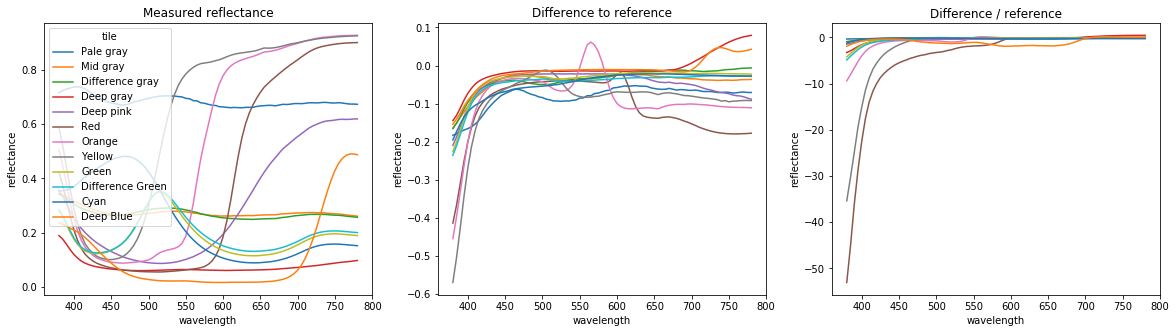

In [70]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))
measured.plot.line(x='wavelength', ax=ax[0])
(reference - measured).plot.line(x='wavelength', add_legend=False, ax=ax[1])
((reference - measured)/reference).plot.line(x='wavelength', add_legend=False, ax=ax[2])
ax[0].set_title('Measured reflectance')
ax[1].set_title('Difference to reference')
ax[2].set_title('Difference / reference')
plt.show()

## Fit of coefficients
Fit coefficients C1-C5 for the model of the difference
$$
\Delta R = R_{ref} - R = C_1 + C_2 R + C_3 \frac{\delta R}{\delta \lambda} + C4 \frac{\delta^2 R}{\delta \lambda^2} + C_5 (1 - R)R
$$
from
> Germer et. al., ''Spectrophotometry: Accurate Measurement of Optical Properties of Materials'', 
>vol.46, p.394

In [37]:
coefs = fit_dataarray(measured.interp_like(reference), reference)

Add the modeled difference to the measured reflectance and compare with the reference data:

In [38]:
reconstruction = apply_model(measured, coefs)

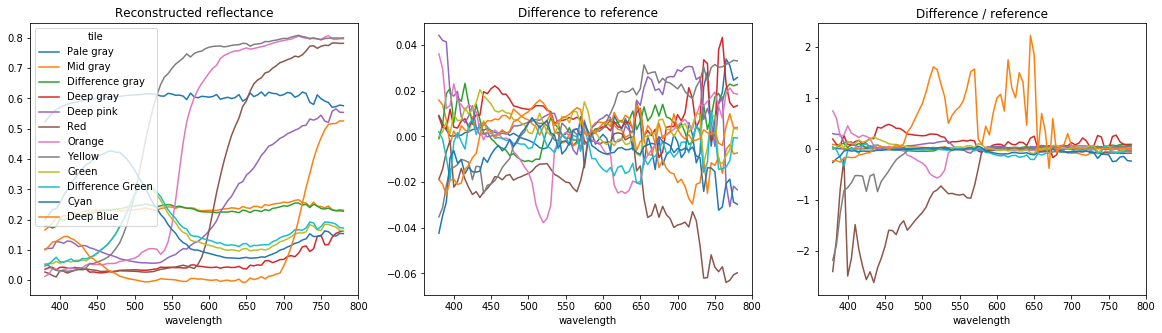

In [71]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))
reconstruction.plot.line(ax=ax[0], x='wavelength')
(reference - reconstruction).plot.line(ax=ax[1], add_legend=False, x='wavelength')
((reference - reconstruction)/reference).plot.line(ax=ax[2], add_legend=False, x='wavelength')
ax[0].set_title('Reconstructed reflectance')
ax[1].set_title('Difference to reference')
ax[2].set_title('Difference / reference')
plt.show()

# Coefficients
As defined by CZ in his Labview UI:

- C1: Offset
- C2: Span
- C3: Wavelength registration
- C4: Bandpass
- C5: Non-linearity

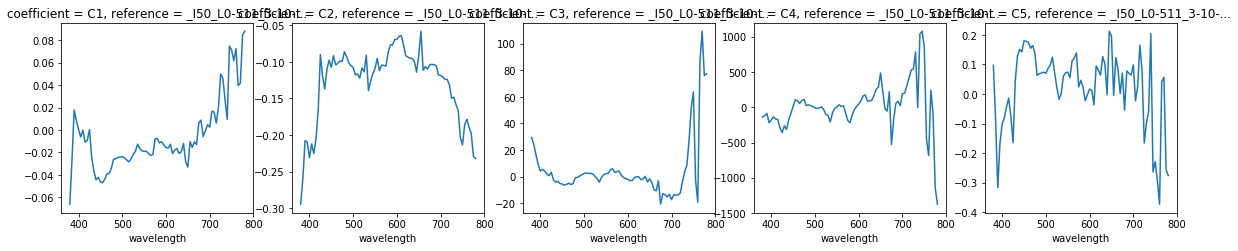

In [40]:
fig, ax = plt.subplots(ncols=5, figsize=(20,3.5))
for k, coef in enumerate(['C1', 'C2', 'C3', 'C4', 'C5']):
    coefs.sel(coefficient=coef).plot.line(x='wavelength', ax=ax[k])
plt.show()